# VPN detection using Network Traffic Classification based on Single Flow Time Series Analysis 

Problem: binary detection of VPN

Raw data from: ISCX-VPN-2016  [1]

-----------------------------------------------------------------------
[1] Gerard Draper-Gil et al. Characterization of Encrypted and VPN Traffic Using Time-related. In ICISSP, pages 407–414, 2016.

In [1]:
import pandas as pd
import numpy as np
import json
import collections

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import lightgbm as lgb
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss


In [2]:
df = pd.read_csv("../cnsm_final_datasets/vpn_iscx_binary.csv")

In [3]:
df

,Unnamed: 0,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,10.8.8.178,1,0,0,0,1.433357e+09,1.433357e+09,443,54269,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,True
1,1,134.170.25.26,1,0,1,0,1.433357e+09,1.433357e+09,54269,443,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,True
2,2,157.56.52.13,3,0,2,0,1.433357e+09,1.433357e+09,56909,40011,...,-341097.010413,0.608031,0.434314,0.233900,NaN,55.388248,2292.470299,-0.371507,0.007280,True
3,3,10.8.8.178,3,0,4,0,1.433357e+09,1.433357e+09,40011,56909,...,89822.936222,0.094477,0.492656,0.284938,NaN,10.541214,138.490636,0.142047,0.165118,True
4,4,134.170.25.26,1,0,149,0,1.433357e+09,1.433357e+09,54269,443,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243874,243874,131.202.240.87,8,0,645,0,1.429121e+09,1.429121e+09,443,9159,...,-113974.395428,0.010243,0.533476,0.320307,NaN,-955.182923,10.450975,-0.000199,0.596337,False
243875,243875,131.202.240.87,26,45,2920,56153,1.429121e+09,1.429121e+09,443,52293,...,-328906.894746,0.879409,0.978421,NaN,NaN,1032.122078,737.468266,0.746391,0.022098,False
243876,243876,74.125.226.175,10,0,4296,0,1.429121e+09,1.429121e+09,9159,443,...,-35284.359489,0.006667,0.505978,0.285870,0.011354,1.055132,0.192964,-0.000199,1.000000,False
243877,243877,131.202.240.87,31,0,948,0,1.429121e+09,1.429121e+09,443,9161,...,18190.410628,0.006667,0.500264,0.287693,-0.015232,1.095998,0.007053,-0.992737,1.000000,False


In [4]:
default_faetures = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
]

statistics_features = [
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
]
distribution_features = [
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
]
time_features = [
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    ]
behavior_features = [
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
]
frequency_features = [
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

features = [
    "PACKETS",
    "PACKETS_REV",
    "BYTES",
    "BYTES_REV",
    "MEAN",
    "MEDIAN",
    "STDEV",
    "VAR",
    "BURSTINESS",
    "Q1",
    "Q3",
    "MIN",
    "MAX",
    "MIN_MINUS_MAX",
    "MODE",
    "COEFFICIENT_OF_VARIATION",
    "AVERAGE_DISPERSION",
    "PERCENT_DEVIATION",
    "ROOT_MEAN_SQUARE",
    "PERCENT_BELOW_MEAN",
    "PERCENT_ABOVE_MEAN",
    "PEARSON_SK1_SKEWNESS",
    "PEARSON_SK2_SKEWNESS",
    "FISHER_MI_3_SKEWNESS",
    "FISHER_PEARSON_g1_SKEWNESS",
    "FISHER_PEARSON_G1_SKEWNESS",
    "GALTON_SKEWNESS",
    "KURTOSIS",
    "ENTROPY",
    "SCALED_ENTROPY",
    "HURST_EXPONENT",
    "BENFORD_LAW_PRESENTED",
    "P_BENFORD",
    "NORMAL_DISTRIBUTION",
    "CNT_DISTRIBUTION",
    "TIME_DISTRIBUTION",
    "AREA_VALUES_DISTRIBUTION",
    "MEAN_SCALED_TIME",
    "MEDIAN_SCALED_TIME",
    "Q1_SCALED_TIME",
    "Q3_SCALED_TIME",
    "DURATION",
    "MEAN_DIFFTIMES",
    "MEDIAN_DIFFTIMES",
    "MIN_DIFFTIMES",
    "MAX_DIFFTIMES",
    "MEAN_SCALED_DIFFTIMES",
    "SIG_SPACES",
    "SWITCHING_METRIC",
    "DIRECTIONS",
    "TRANSIENTS",
    "CNT_ZEROS",
    "CNT_NZ_DISTRIBUTION",
    "BIGGEST_CNT_1_SEC",
    "PERIODICITY",
    "VAL",
    "TIME",
    "MIN_POWER",
    "MAX_POWER",
    "MIN_POWER_FREQ",
    "MAX_POWER_FREQ",
    "POWER_MEAN",
    "POWER_STD",
    "POWER_MODE",
    "SPECTRAL_ENERGY",
    "SPECTRAL_ENTROPY",
    "SPECTRAL_KURTOSIS",
    "SPECTRAL_SKEWNESS",
    "SPECTRAL_ROLLOFF",
    "SPECTRAL_CENTROID",
    "SPECTRAL_SPREAD",
    "SPECTRAL_SLOPE",
    "SPECTRAL_CREST",
    "SPECTRAL_FLUX",
    "SPECTRAL_BANDWIDTH",
    "PERIODICITY_SCDF",
]

In [5]:
import sklearn
pd.set_option('display.max_columns', None)

df['LABEL'] = df.LABEL.astype('category')
df["LABEL_code"] = df["LABEL"].cat.codes

bool_features = ["TRANSIENTS", "BENFORD_LAW_PRESENTED", "SIG_SPACES", "PERIODICITY","PERIODICITY_SCDF"]


for F in features:
    if F in bool_features:
        continue
    if F in distribution_features:
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    elif F in ["DIRECTIONS","NORMAL_DISTRIBUTION"]: 
        df.replace([np.inf], 0.5, inplace=True)
        df.replace([-np.inf], 0.5, inplace=True)
        df.loc[df[F].isnull(), F] = 0.5
    # elif F in frequency_features: 
    #     df.replace([np.inf], -1, inplace=True)
    #     df.replace([-np.inf], -1, inplace=True)
    #     df.loc[df[F].isnull(), F] = -1
    # elif F in directions_features: 
    #     df.replace([np.inf], -1, inplace=True)
    #     df.replace([-np.inf], -1, inplace=True)
    #     df.loc[df[F].isnull(), F] = -1
    # else:
    #     df.replace([np.inf], 0, inplace=True)
    #     df.replace([-np.inf], 0, inplace=True)
    #     df.loc[df[F].isnull(), F] = 0


for F in bool_features:
    df.loc[df[F].isnull(), F] = False
    df[F] = df[F].astype('bool')

In [6]:
df

,Unnamed: 0,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,MEAN,MEDIAN,STDEV,VAR,BURSTINESS,Q1,Q3,MIN,MAX,MIN_MINUS_MAX,MODE,COEFFICIENT_OF_VARIATION,AVERAGE_DISPERSION,PERCENT_DEVIATION,ROOT_MEAN_SQUARE,PERCENT_BELOW_MEAN,PERCENT_ABOVE_MEAN,PEARSON_SK1_SKEWNESS,PEARSON_SK2_SKEWNESS,FISHER_MI_3_SKEWNESS,FISHER_PEARSON_g1_SKEWNESS,FISHER_PEARSON_G1_SKEWNESS,GALTON_SKEWNESS,KURTOSIS,ENTROPY,SCALED_ENTROPY,HURST_EXPONENT,BENFORD_LAW_PRESENTED,P_BENFORD,NORMAL_DISTRIBUTION,CNT_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_SCALED_TIME,MEDIAN_SCALED_TIME,Q1_SCALED_TIME,Q3_SCALED_TIME,DURATION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES,SIG_SPACES,SWITCHING_METRIC,TRANSIENTS,CNT_ZEROS,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,MIN_POWER,MAX_POWER,MIN_POWER_FREQ,MAX_POWER_FREQ,POWER_MEAN,POWER_STD,POWER_MODE,SPECTRAL_ENERGY,SPECTRAL_ENTROPY,SPECTRAL_KURTOSIS,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL,LABEL_code
0,0,10.8.8.178,1,0,0,0,1.433357e+09,1.433357e+09,443,54269,60,60.0,60.000000,0,0.000000,60.0,60.00,60,60,0,60,100.000000,0,0.000000,60.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,False,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,False,0.000000,False,0.0,0.0,60,1.000000,False,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,False,True,1
1,1,134.170.25.26,1,0,1,0,1.433357e+09,1.433357e+09,54269,443,61,61.0,61.000000,0,0.000000,61.0,61.00,61,61,0,61,100.000000,0,0.000000,61.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,False,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,False,0.000000,False,0.0,0.0,61,1.000000,False,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,False,True,1
2,2,157.56.52.13,3,0,2,0,1.433357e+09,1.433357e+09,56909,40011,60,60.0,1.000000,2,-0.967213,60.0,61.00,60,62,2,60,1.666667,0,0.000000,60.673992,0.000000,0.333333,0.000000,120.000000,7262.666667,6.666667e-01,1.632993e+00,1.000000,5.333333,0.918296,0.579380,0.535744,False,0.477121,0.0,0.0,0.340934,0.750000,7.299830,0.488201,0.000000,21.411289,21.411289,10.705644,10.705644,0.488201,20.923088,0.511667,False,1.000000,False,0.0,0.0,182,1.000000,False,0,0.0,-671.921077,47.390194,0.979537,0.608031,0.855600,9.630094,1.00000,4278.000802,NaN,2.382317e+07,-341097.010413,0.608031,0.434314,0.233900,NaN,55.388248,2292.470299,-0.371507,True,True,1
3,3,10.8.8.178,3,0,4,0,1.433357e+09,1.433357e+09,40011,56909,61,62.0,1.000000,1,-0.967742,61.0,62.00,60,62,2,62,1.639344,1,1.639344,61.340579,0.333333,0.666667,-1.000000,121.000000,3721.333333,3.333333e-01,8.164966e-01,1.000000,1.000000,0.918296,0.579380,0.535744,False,0.477121,0.0,0.0,0.336774,0.750000,7.119728,0.218230,0.000000,21.140954,21.140954,10.570477,10.570477,0.218230,20.922724,0.505215,False,1.000000,False,0.0,0.0,184,1.000000,False,0,0.0,-1.349542,10.273650,0.189440,0.331487,0.974617,0.250358,1.00000,4873.086578,NaN,3.265305e+06,89822.936222,0.094477,0.492656,0.284938,NaN,10.541214,138.490636,0.142047,True,True,1
4,4,134.170.25.26,1,0,149,0,1.433357e+09,1.433357e+09,54269,443,209,209.0,209.000000,0,0.000000,209.0,209.00,209,209,0,209,100.000000,0,0.000000,209.000000,0.000000,0.000000,0.000000,2.000000,-3.000000,0.000000e+00,-0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000,False,0.301030,0.0,0.0,0.500000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,False,0.000000,False,0.0,0.0,209,1.000000,False,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,False,True,1
...,...,...

In [7]:
print(f"vpn: {len(df[df['LABEL'] == True])}\tclear: {len(df[df['LABEL'] == False])}")

vpn: 23078	clear: 220801


In [8]:
df = df[["LABEL_code"] + features].copy()

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

df = clean_dataset(df)

In [10]:
df.shape

(13324, 77)

In [11]:
print(f"vpn: {len(df[df['LABEL_code'] == 1])}\tclear: {len(df[df['LABEL_code'] == 0])}")

vpn: 8154	clear: 5170


In [12]:
df_validation = df.sample(n = 2000)
df_features =  df[~df.isin(df_validation)].dropna()

In [13]:
def get_confusion_matrix(y_test, y_pred):
    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_test, y_pred)
    percentage_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    return matrix, percentage_matrix

def plot_confusion_matrix(matrix, percentage_matrix, model=""):
    # Build the plot
    fig, ax = plt.subplots(1, 2,figsize=(15,5))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[0])
    sns.heatmap(percentage_matrix, annot=True, annot_kws={'size':10}, fmt='g',
                cmap=plt.cm.Greens, linewidths=0.2, ax=ax[1])
    # Add labels to the plot
    plt.tick_params(axis='both', which='minor', labelsize=5)
    # tick_marks = np.arange(len(classifications_array)) + 0.5
    # plt.xticks(tick_marks, classifications_array, rotation=85)
    # plt.yticks(tick_marks, classifications_array, rotation=0)
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')
    ax[0].set_title(f'Absolute Confusion Matrix for {model}')
    ax[1].set_xlabel('Predicted label')
    ax[1].set_ylabel('True label')
    ax[1].set_title(f'Relative Confusion Matrix for {model}')
    # pyplot.savefig("ddos_timeseries_plugin_classification.eps", format="eps")
    plt.show()

### New tunning

In [15]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_absolute_error

def tunne_together_XGBoost_classification(df_tunne, _features, verbose=True):
    X=df_tunne[_features]  # Features
    y=df_tunne['LABEL_code']  # Labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)
    
    def objective(space):
        clf = XGBClassifier(
                        n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), 
                        gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']), 
                        # subsample=int(space['subsample']),
                        # eta=space['eta'],
                            )

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric=["auc","error","logloss"],
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        # accuracy = mean_absolute_error(y_test, pred)
        # accuracy = accuracy_score(y_test, pred)
        accuracy = f1_score(y_test, pred)
        if verbose is True:
            print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
    
    space={'max_depth': hp.quniform("max_depth", 30, 100, 5),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 20, 1),
        'n_estimators': hp.quniform('n_estimators', 80, 400, 20),
        # 'subsample': hp.quniform('subsample', 3, 20, 1),
        # 'eta': hp.quniform('eta', 0.005, 0.3, 0.005),
        'seed': 0
    }
    
    trials = Trials()
    
    best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
        
    print("The best hyperparameters are : ","\n")
    print(best_hyperparams)
    return best_hyperparams

In [16]:
best_hyperparams = tunne_together_XGBoost_classification(df_features, features, verbose=False)

100%|██████████| 100/100 [00:54<00:00,  1.84trial/s, best loss: -0.9324681566931026]
The best hyperparameters are :  

{'colsample_bytree': 0.0773613631427769, 'gamma': 1.719671432108421, 'max_depth': 80.0, 'min_child_weight': 14.0, 'n_estimators': 340.0, 'reg_alpha': 0.0, 'reg_lambda': 0.5886000493396555}


In [17]:
def XGBoost_classification_tunned(best_hyperparams):
      X=df_features[features]  # Features
      y=df_features['LABEL_code']  # Labels
      #Split on train and test
      X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
      X_train = X_train_a[features]
      X_test = X_test_a[features] 
      model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
            gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
            # subsample=int(best_hyperparams['subsample']),
            # eta=best_hyperparams['eta'],
      )
      eval_set=[(X_train, y_train), (X_test, y_test)]
      model.fit(X_train, y_train, eval_metric=["auc","error","logloss"], eval_set=eval_set, verbose=False)
      y_pred = model.predict(X_test)
      
      accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
      precision = precision_score(y_test, y_pred)  * 100
      recall = recall_score(y_test, y_pred)  * 100
      F1 = f1_score(y_test, y_pred)  * 100
      print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1))
      matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
      plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")
      return model

92.02 & 92.45 & 94.72 & 93.57 \\


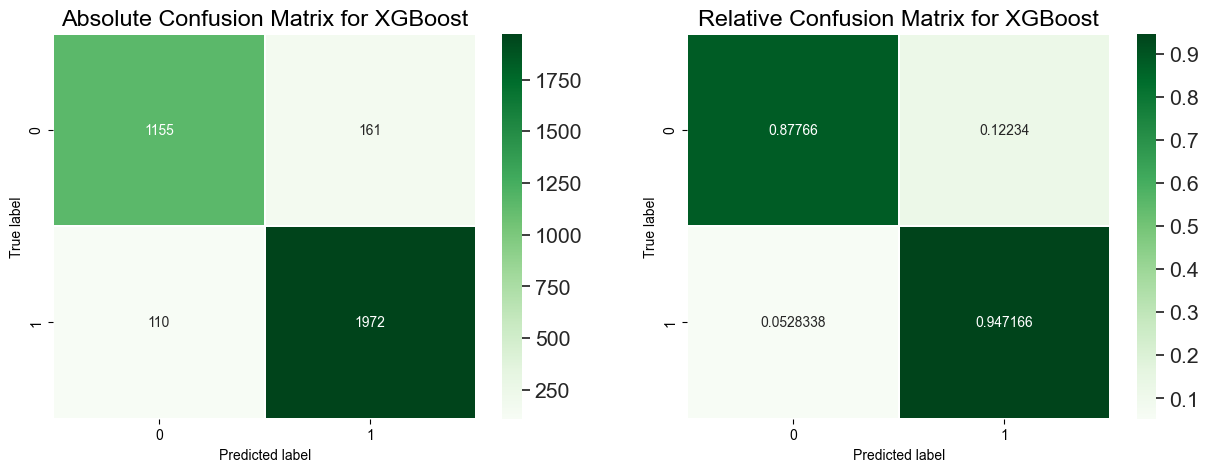

In [18]:
model = XGBoost_classification_tunned(best_hyperparams)

In [19]:

def while_XGBoost_classification_tunned(best_hyperparams, cycles=100):
    X=df_features[features]  # Features
    y=df_features['LABEL_code']  # Labels
    best_results = (0,"",None,None, None)
    i = 0
    print(f"\r{i}", end="")
    for i in range(cycles):
        print(f"\r{i}", end="", flush=True)
        tmp_f1 = 0
        tmp_str = ""
        #Split on train and test
        X_train_a, X_test_a, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test
        for F, N in zip(
                [ features], # statistics_features, time_features, distribution_features, frequency_features, behavior_features, 
                [ "All"], # "Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", 
        ):
                X_train = X_train_a[F]
                X_test = X_test_a[F] 
                model = XGBClassifier(
                        n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), 
                        # gamma = best_hyperparams['gamma'],
                        # reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                        # colsample_bytree=int(best_hyperparams['colsample_bytree']),
                        # subsample=int(best_hyperparams['subsample']),
                        # eta=best_hyperparams['eta'],
                )
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
                precision = precision_score(y_test, y_pred)  * 100
                recall = recall_score(y_test, y_pred)  * 100
                F1 = f1_score(y_test, y_pred)  * 100
                if N == "All":
                    tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\hline"
                    tmp_str += "\n"
                    tmp_f1 = F1
                elif N in ["Statistical-based", "Distribution-based", "Behavior-based"]:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
                else:
                    tmp_str += "& \cellcolor{Gray} \\textbf{"
                    tmp_str += N
                    tmp_str += "} & \\rowcolor{LigthGray} " 
                    tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
                    tmp_str += "\n"
                    tmp_str += "\cline{2-6}"
                    tmp_str += "\n"
        if best_results[0] < tmp_f1:
            matrix, percentage_matrix = get_confusion_matrix(y_test, y_pred)
            best_results = (tmp_f1, tmp_str, matrix, percentage_matrix, model)
    print("")
    print("")
    print("")
    print(best_results[0])
    print(best_results[1])
    plot_confusion_matrix(best_results[2], best_results[3], model="XGBoost")
    return best_results[4]

24


95.908111988514
\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}94.97 & 95.57 & 96.25 & 95.91 \\
\hline



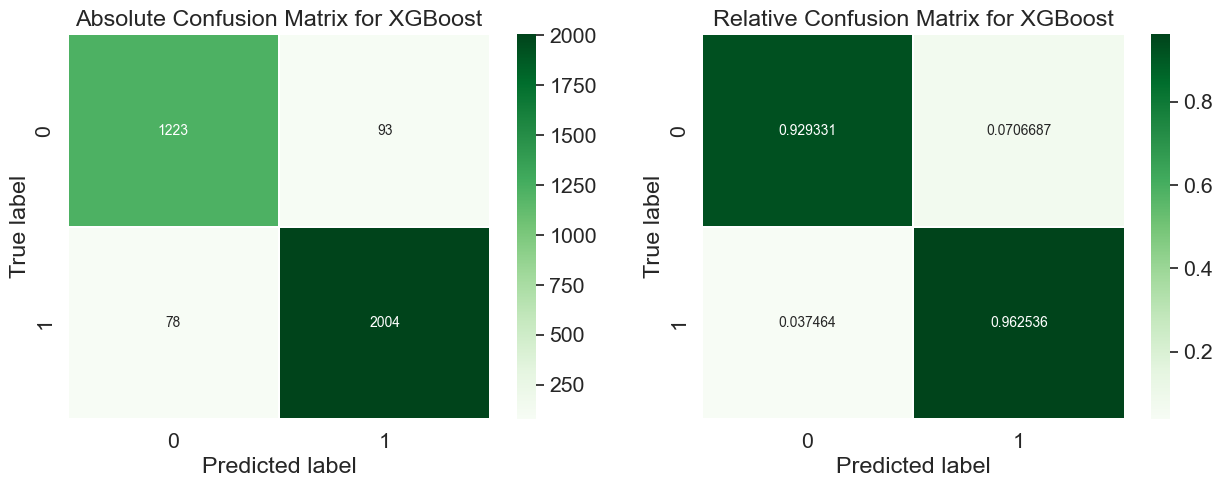

In [22]:
best_model = while_XGBoost_classification_tunned(best_hyperparams, cycles=25)

# Validation

\multirow{-6}{*}{\rotatebox{90}{\centering \textbf{Our approach}}} & \cellcolor{Gray} \textbf{All} & \rowcolor{LigthGray}94.15 & 94.78 & 95.64 & 95.21 \\
\hline



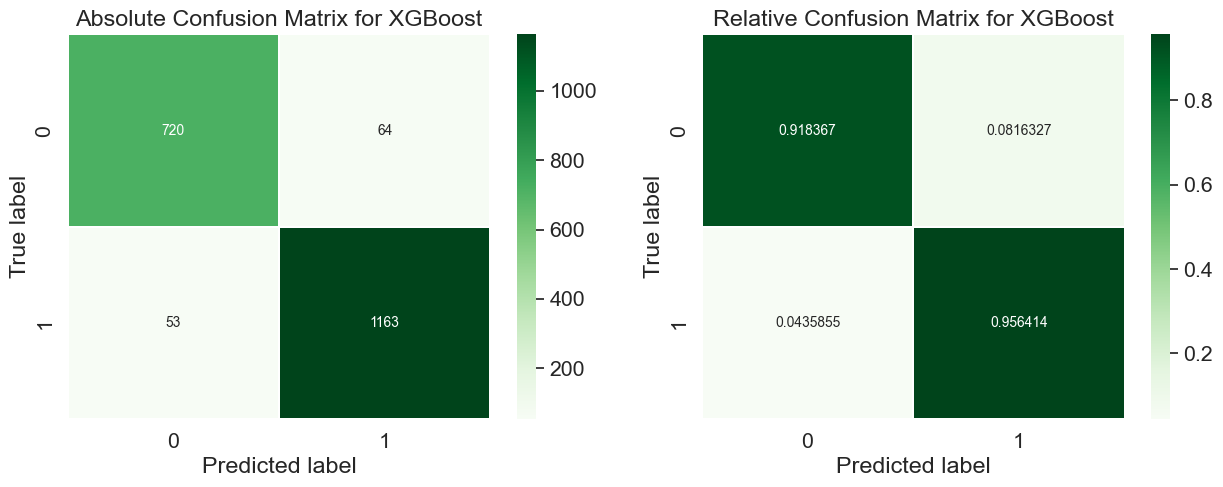

In [23]:
X_validation=df_validation[features]  # Features
y_validation=df_validation['LABEL_code']  # Labels
    

y_pred = best_model.predict(X_validation)
accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
precision = precision_score(y_validation, y_pred)  * 100
recall = recall_score(y_validation, y_pred)  * 100
F1 = f1_score(y_validation, y_pred)  * 100
                
tmp_str = ""
tmp_str += "\multirow{-6}{*}{\\rotatebox{90}{\centering \\textbf{Our approach}}} & \cellcolor{Gray} \\textbf{All} & \\rowcolor{LigthGray}" 
tmp_str += "{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(accuracy,precision,recall,F1)
tmp_str += "\n"
tmp_str += "\hline"
tmp_str += "\n"
print(tmp_str)

matrix, percentage_matrix = get_confusion_matrix(y_validation, y_pred)
plot_confusion_matrix(matrix, percentage_matrix, model="XGBoost")

# 94.75 & 95.71 & 96.08 & 95.90

In [24]:
import csv

problem = "VPN-ISCX-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([problem, "-", accuracy, precision, recall, F1, 0, 0, 0])

# Feature importance

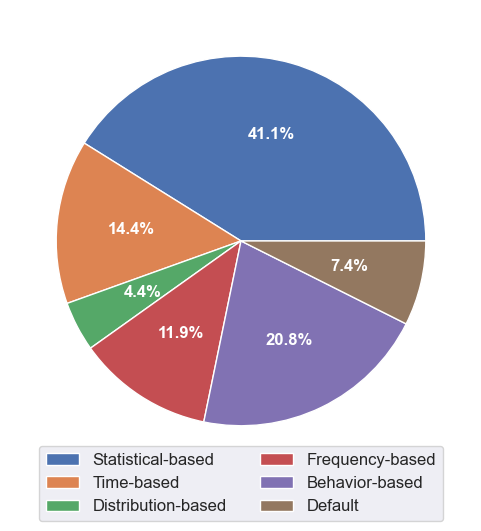

In [25]:
feat_importances = pd.Series(best_model.feature_importances_, index = X_validation.columns).sort_values(ascending = True)

f_sf = feat_importances[statistics_features].sum()
f_tf = feat_importances[time_features].sum()
f_df = feat_importances[distribution_features].sum()
f_ff = feat_importances[frequency_features].sum()
f_bf = feat_importances[behavior_features].sum()
f_def = feat_importances[default_faetures].sum()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
data = [f_sf, f_tf, f_df, f_ff, f_bf, f_def]
ingredients = ["Statistical-based", "Time-based", "Distribution-based",  "Frequency-based",  "Behavior-based", "Default"]
def func(pct, allvals):
    return "{:.1f}%".format(pct)
wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          loc="center",
          bbox_to_anchor=(0.5, 0, 0, -0.05),
          prop={'size': 12},
          ncol=2)
plt.setp(autotexts, size=12, weight="bold")
plt.show()

In [26]:
data

[0.4111903, 0.14369492, 0.043636773, 0.11918937, 0.20821947, 0.074069194]

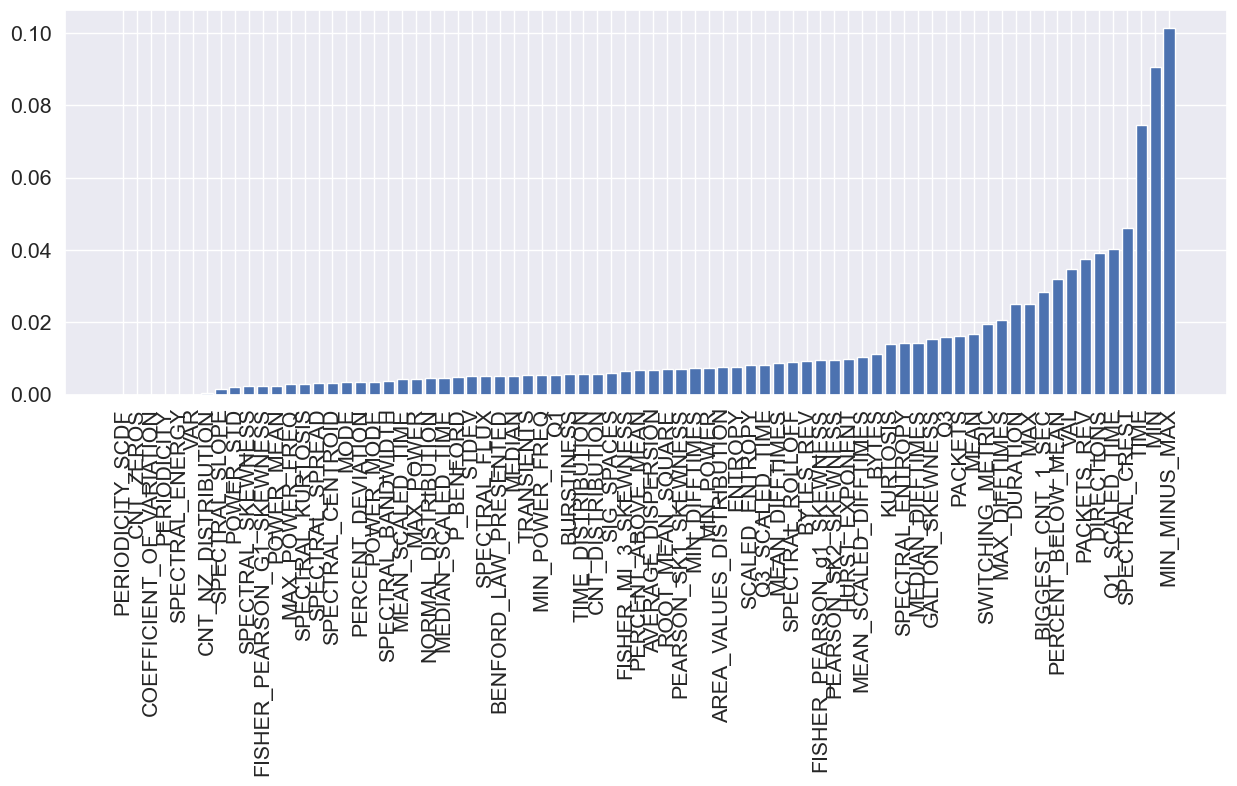

In [27]:
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(feat_importances.keys(), feat_importances.values)
plt.xticks(rotation = 90)
plt.show()

In [28]:
feat_importances

PERIODICITY_SCDF            0.000000
CNT_ZEROS                   0.000000
COEFFICIENT_OF_VARIATION    0.000000
PERIODICITY                 0.000000
SPECTRAL_ENERGY             0.000000
                              ...   
Q1_SCALED_TIME              0.040327
SPECTRAL_CREST              0.046033
TIME                        0.074506
MIN                         0.090565
MIN_MINUS_MAX               0.101317
Length: 76, dtype: float32

In [29]:
feat_importances.to_dict()

{'PERIODICITY_SCDF': 0.0,
 'CNT_ZEROS': 0.0,
 'COEFFICIENT_OF_VARIATION': 0.0,
 'PERIODICITY': 0.0,
 'SPECTRAL_ENERGY': 0.0,
 'VAR': 0.0,
 'CNT_NZ_DISTRIBUTION': 0.00039276928873732686,
 'SPECTRAL_SLOPE': 0.00143794110044837,
 'POWER_STD': 0.002024476183578372,
 'SPECTRAL_SKEWNESS': 0.0023108862806111574,
 'FISHER_PEARSON_G1_SKEWNESS': 0.0024222282227128744,
 'POWER_MEAN': 0.002479980932548642,
 'MAX_POWER_FREQ': 0.0029198636766523123,
 'SPECTRAL_KURTOSIS': 0.0029719627927988768,
 'SPECTRAL_SPREAD': 0.00320682511664927,
 'SPECTRAL_CENTROID': 0.003238083329051733,
 'MODE': 0.0033756678458303213,
 'PERCENT_DEVIATION': 0.003418384585529566,
 'POWER_MODE': 0.00346141355112195,
 'SPECTRAL_BANDWIDTH': 0.00370126124471426,
 'MEAN_SCALED_TIME': 0.004207841586321592,
 'MAX_POWER': 0.0042193131521344185,
 'NORMAL_DISTRIBUTION': 0.00463435985147953,
 'MEDIAN_SCALED_TIME': 0.004652165807783604,
 'P_BENFORD': 0.004804905503988266,
 'STDEV': 0.00504213897511363,
 'SPECTRAL_FLUX': 0.00504984240978956

# FEATURE SELECTION

In [35]:
def perform_val(selected_features, best_hyperparams=None, cycles=25):
    if best_hyperparams is None:
        best_hyperparams = tunne_together_XGBoost_classification(df_features, selected_features, verbose=False)
    
    X=df_features[selected_features]  # Features
    y=df_features['LABEL_code']  # Labels

    best = 0
    best_model = None
    for i in range(0, cycles):    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y) # 70% training and 30% test   
        model = XGBClassifier(
            n_estimators = int(best_hyperparams['n_estimators']), max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
            reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
            colsample_bytree=int(best_hyperparams['colsample_bytree']),
        )
        model.fit(X_train, y_train)                
        y_pred = model.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)  * 100
        precision = precision_score(y_test, y_pred)  * 100
        recall = recall_score(y_test, y_pred)  * 100
        F1 = f1_score(y_test, y_pred)  * 100
        if F1 > best:   
            best = F1
            best_model = model
            
    
    X_validation=df_validation[selected_features]  # Features
    y_validation=df_validation['LABEL_code']  # Labels

    y_pred = best_model.predict(X_validation)
    accuracy = metrics.accuracy_score(y_validation, y_pred)  * 100
    precision = precision_score(y_validation, y_pred)  * 100
    recall = recall_score(y_validation, y_pred)  * 100
    F1 = f1_score(y_validation, y_pred)  * 100
    
    return accuracy,precision,recall,F1

In [36]:
import FEATURE_REDUCTED as FR
REPORTS = []

report = perform_val(FR.botnet_best_features)
REPORTS.append(report)
report = perform_val(FR.doh_best_features)
REPORTS.append(report)
report = perform_val(FR.dos_best_features)
REPORTS.append(report)
report = perform_val(FR.dns_malware_features)
REPORTS.append(report)
report = perform_val(FR.tor_features)
REPORTS.append(report)
report = perform_val(FR.vpn_features)
REPORTS.append(report)
report = perform_val(FR.all_best_features)
REPORTS.append(report)
report = perform_val(FR.combo_features)
REPORTS.append(report)
report = perform_val(FR.combo_2_features)
REPORTS.append(report)
report = perform_val(FR.crypto_features)
REPORTS.append(report)

100%|██████████| 100/100 [00:28<00:00,  3.54trial/s, best loss: -0.8967988533205923]
The best hyperparameters are :  

{'colsample_bytree': 0.734946619441569, 'gamma': 3.0126933161747598, 'max_depth': 40.0, 'min_child_weight': 1.0, 'n_estimators': 280.0, 'reg_alpha': 1.0, 'reg_lambda': 0.2701996243774989}
100%|██████████| 100/100 [00:27<00:00,  3.59trial/s, best loss: -0.9274116523400191]
The best hyperparameters are :  

{'colsample_bytree': 0.19777577697830295, 'gamma': 2.626535144537812, 'max_depth': 70.0, 'min_child_weight': 5.0, 'n_estimators': 160.0, 'reg_alpha': 0.0, 'reg_lambda': 0.17814087641217374}
100%|██████████| 100/100 [00:24<00:00,  4.11trial/s, best loss: -0.9224137931034482]
The best hyperparameters are :  

{'colsample_bytree': 0.4019379761348738, 'gamma': 1.0205987212817371, 'max_depth': 75.0, 'min_child_weight': 11.0, 'n_estimators': 300.0, 'reg_alpha': 0.0, 'reg_lambda': 0.3476542585993747}
100%|██████████| 100/100 [00:26<00:00,  3.74trial/s, best loss: -0.91355084

In [37]:
import csv

problem = "VPN-ISCX-binary"
with open("feature_reduction_results.csv", "a") as f:
    writer = csv.writer(f)
    for report, f_set in zip(REPORTS, FR.FEATURE_SETS):
        writer.writerow([problem, f_set, report[0], report[1], report[2], report[3], 0, 0, 0])